In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit import QuantumRegister

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [3]:
pip install pennylane-qiskit

  Using cached PennyLane_qiskit-0.15.0-py3-none-any.whl (21 kB)
  Using cached PennyLane-0.15.0-py3-none-any.whl (454 kB)
  Using cached semantic_version-2.6.0-py3-none-any.whl (14 kB)
  Using cached autograd-1.3-py3-none-any.whl


  Using cached future-0.18.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install qiskit-tensorflow
#import tensorflow as tf

In [5]:
import pennylane as qml
from pennylane.templates import AmplitudeEmbedding

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(f=None):
    AmplitudeEmbedding(features=f, wires=range(2), normalize=True)
    return qml.expval(qml.PauliZ(0))

In [6]:
def oneDimVecConverter(thisList):
    encoded = []
    for i in range(5,len(thisList)):
        top = thisList[i-5:i-5+2]
        bottom = thisList[i-2:i]
        window = top + bottom
        #print(newList)
        encoded.append(circuit(f=window))
    return encoded

In [7]:
from sklearn.preprocessing import MinMaxScaler
data = [[-1, 2, 4, 8], [-2, 6, 4, 3], [0, 10, 1, 2], [1, 18, 9, 6]]
scaler = MinMaxScaler()
scaler.fit(data)
scaledData = scaler.transform(data)

scaledData = scaledData.tolist()
#print(scaledData)

oneDimVec = []
for i in range(4):
    for j in range(4):
        oneDimVec.append(scaledData[i][j])

someList = oneDimVecConverter(oneDimVec)
someList = [num for num in someList]
someList

[tensor(-0.8, requires_grad=True),
 tensor(0.38461538, requires_grad=True),
 tensor(0.69767442, requires_grad=True),
 tensor(0.71173848, requires_grad=True),
 tensor(-0.76623377, requires_grad=True),
 tensor(-0.54738878, requires_grad=True),
 tensor(-0.19502075, requires_grad=True),
 tensor(1., requires_grad=True),
 tensor(-0.18032787, requires_grad=True),
 tensor(-0.77777778, requires_grad=True),
 tensor(-1., requires_grad=True)]

<h1> ----------------------------------------------------------------- </h1>

In [2]:
numOfInputs = 4
numOfOutputs = 4

In [10]:
# Function: Creates Controlled-NOT Gates (CNOT) and Barriers for aesthetics 
# Parameters: 'circuit', 'channels'
#     'circuit' : quantum circuit 
#    'channels' : number of active states in circuit (generally same as 'numIn')
def CNOT_and_Barriers(circuit, channels):
    for channel in range(channels-1):
        circuit.cx(channel, channel+1)
        for count in range(channel):
            circuit.barrier(count)

def clusterStateQC(numIn, numOut, quReg):
    #qr1 = QuantumRegister(numIn)
    
    # Define Cluster State Quantum Circuit (abbreviated: cs_qc) 
    # numIn = number of initial quantum states 
    # numOut = number of output states of cs_qc (likely same as numIn)
    cs_qc = QuantumCircuit()
    #numIn, numOut
    cs_qc.add_register(quReg)
    # For testing this circuit, we can reset all inputs to this circuit to 0. 
    # Ideally, the CtoQ encoder code will encode classical data to initial quantum states as inputs to this circuit. 
    #for i in range(numIn):
    #    cs_qc.reset(i)
    
    # Hadamard Gates for all incoming feature inputs to achieve superposition of states
    for num in range(numIn):
        cs_qc.h(quReg[num])
    #cs_qc.h(range(numIn))
        
    # Place Controlled-NOT Gates (CNOT) for entanglement and barriers for aesthetics
    #CNOT_and_Barriers(cs_qc, numIn)
    
    # Place Pauli-Y Gates (Y) for rotation of states about y-axis 
    for num in range(numIn):
        cs_qc.y(quReg[num])
    #cs_qc.y(range(numIn))
    
    # Place Controlled-NOT Gates (CNOT) for entanglement and barriers for aesthetics
    #CNOT_and_Barriers(cs_qc, numIn)  
    
    # For testing this circuit, we can measure the outputs
    # We should expect to see that the probabilities for the outputs of the circuit vary each time we re-execute the simulation. 
    #for i in range(numOut):
    #    cs_qc.measure(i,i)
    
    return cs_qc

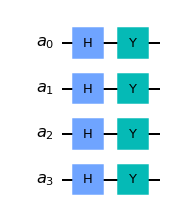

In [11]:
#finalCircuit = QuantumCircuit(numOfInputs, numOfOutputs)
finalCircuit = QuantumCircuit()
#finalCircuit.add_register(qr)
qr = QuantumRegister(numOfInputs,'a')
#finalCircuit.add_register(qr)

#initial_state = [oneDimVec[0],1]
#for i in range(numOfInputs):
#    None
    #finalCircuit.initialize([oneDimVec[i],oneDimVec[i+1]], i) # Apply initialisation operation to the 0th qubit
    #finalCircuit.reset(someList[i])
#finalCircuit.barrier()

finalCircuit += clusterStateQC(numIn=numOfInputs, numOut=numOfOutputs, quReg=qr)
    
finalCircuit.draw()

In [6]:
import math
pi = math.pi

default = pi/2 
params = {'theta' : [round(pi*i/8,2) for i in range(numOfInputs)], 
            'phi' : [round(pi*i/8,2) for i in range(numOfInputs)], 
            'lam' : [round(pi*i/8,2) for i in range(numOfInputs)]}
numOfLayers = 2
parameters = {}
for i in range(numOfLayers):
    parameters[i] = params

In [7]:
def qConvLayer(paramDict, shift, inputs):
    qConv = QuantumCircuit(inputs)
    for i in range(0+shift,inputs-1,2):
        index = int(i)
        if (i%2==shift):
            qConv.cu3(paramDict['theta'][index], paramDict['phi'][index], paramDict['lam'][index], 
                      control_qubit=index, target_qubit=index+1)
    return qConv

In [8]:
def qPoolLayer(inputs):
    qPool = QuantumCircuit(inputs,inputs)
    for i in range(inputs):
        j=i
        if (i%2==0):
            qPool.measure(i,j)
    qPool.barrier()
    return qPool

<ipython-input-7-8a2bc7434711>:6: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  qConv.cu3(paramDict['theta'][index], paramDict['phi'][index], paramDict['lam'][index],
<ipython-input-9-9b47e293653e>:2: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  finalCircuit += qConvLayer(params, 0, numOfInputs) + qConvLayer(params, 1, numOfInputs)
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


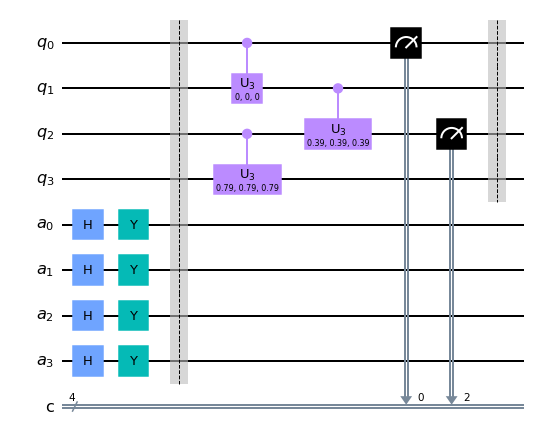

In [9]:
finalCircuit.barrier()
finalCircuit += qConvLayer(params, 0, numOfInputs) + qConvLayer(params, 1, numOfInputs)
finalCircuit += qPoolLayer(numOfInputs)
finalCircuit.draw()

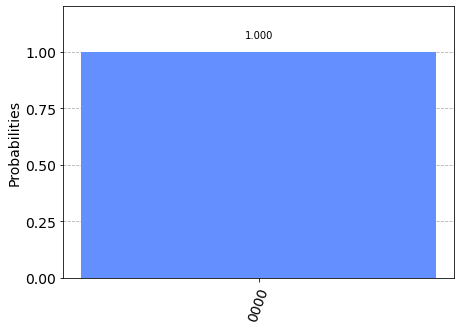

In [10]:
sim = Aer.get_backend('qasm_simulator')  # this is the simulator we'll use
qobj = assemble(finalCircuit)  # this turns the circuit into an object our backend can run
result = sim.run(qobj).result()  # we run the experiment and get the result from that experiment
# from the results, we get a dictionary containing the number of times (counts)
# each result appeared
counts = result.get_counts()
# and display it on a histogram
plot_histogram(counts)